In [2]:
from RSA_tuner import *

In [3]:
class ObservableDataset(Dataset):
	"""
	Converts observable dataset into PyTorch syntax.
	"""
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return self.data.shape[0]

	def __getitem__(self, idx):
		sample = self.data[idx]
		return sample

In [4]:
def a_b_grid(x_range, y_range, n_points):
    """
    Creates a grid of values within a two-dimensional range and returns it in a flattened tensor.

    Parameters:
    x_range (tuple): A tuple of (min, max) for the x-axis range.
    y_range (tuple): A tuple of (min, max) for the y-axis range.
    steps (int): --- The number of steps/points in each dimension.

    Returns:
    torch.Tensor: A flattened tensor containing all the grid points.
    """
    # Create linearly spaced points for each range
    x_points = torch.linspace(x_range[0], x_range[1], n_points)
    y_points = torch.linspace(y_range[0], y_range[1], n_points)

    # Create a meshgrid from the x and y points
    x_grid, y_grid = torch.meshgrid(x_points, y_points, indexing='ij')

    # Flatten the grid and stack the coordinates
    grid_flattened = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

    return grid_flattened

In [7]:
# Paths to the datasets
exp_hadrons_PATH       = '../data/structured_data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e4.npy'
sim_hadrons_PATH       = '../data/structured_data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e4.npy'
sim_accept_reject_PATH = '../data/structured_data/pgun_qqbar_mT2_accept_reject_a_0.72_b_0.88_sigma_0.335_N_1e4.npy'
sim_fPrel_PATH         = '../data/structured_data/pgun_qqbar_fPrel_a_0.72_b_0.88_sigma_0.335_N_1e4.npy'

# Load the arrays
exp_hadrons       = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons       = np.load(sim_hadrons_PATH, mmap_mode="r")
sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")

# Print dataset shapes
print('Experimental observable shape:', exp_hadrons.shape)
print('Simulated observable shape:', sim_hadrons.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Restrict to a subset of the full dataset (for memory)
N_events = int(10000)

# Extract the hadron multiplicity
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])

# Convert into torch objects
sim_mult          = torch.Tensor(sim_mult[0:N_events].copy())
sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy())
sim_fPrel         = torch.Tensor(sim_fPrel[0:N_events].copy())
exp_mult          = torch.Tensor(exp_mult[0:N_events].copy())

# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term proportional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon

# Print dataset shapes
print('Experimental multiplicity shape:', exp_mult.shape)
print('Simulated multiplicity shape:', sim_mult.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Prepare data for DataLoader
sim_mult          = ObservableDataset(sim_mult)
sim_accept_reject = ObservableDataset(sim_accept_reject)
sim_mT            = ObservableDataset(sim_fPrel)
exp_mult          = ObservableDataset(exp_mult)

Experimental observable shape: (10000, 75, 5)
Simulated observable shape: (10000, 75, 5)
Simulated z shape: (10000, 105, 101)
Simulated fPrel shape: (10000, 105, 100)
Experimental multiplicity shape: torch.Size([10000])
Simulated multiplicity shape: torch.Size([10000])
Simulated z shape: torch.Size([10000, 105, 101])
Simulated fPrel shape: torch.Size([10000, 105, 100])


In [8]:
# Set batch size -- set it eqaul to the number of events, we only want one 'batch'
batch_size = N_events

# Initialize data-loaders
sim_observable_dataloader    = DataLoader(sim_mult,          batch_size = batch_size, shuffle = False)
sim_accept_reject_dataloader = DataLoader(sim_accept_reject, batch_size = batch_size, shuffle = False)
sim_fPrel_dataloader         = DataLoader(sim_fPrel,         batch_size = batch_size, shuffle = False)
exp_observable_dataloader    = DataLoader(exp_mult,          batch_size = batch_size, shuffle = False)

In [9]:
print('Size of sim_observable_dataloader:', len(sim_observable_dataloader.dataset))
print('Size of sim_accept_reject_dataloader:', len(sim_accept_reject_dataloader.dataset))
print('Size of sim_fPrel_dataloader:', len(sim_fPrel_dataloader.dataset))
print('Size of exp_observable_dataloader:', len(exp_observable_dataloader.dataset))

Size of sim_observable_dataloader: 10000
Size of sim_accept_reject_dataloader: 10000
Size of sim_fPrel_dataloader: 10000
Size of exp_observable_dataloader: 10000


In [10]:
# Training hyperparameters
over_sample_factor = 10.0
# The flow map will be dependent on the learning rate (size of the gradients)
learning_rate = 0.01
fixed_binning = True
# Length of event buffer
dim_multiplicity  = sim_accept_reject_dataloader.dataset.data.shape[1]
dim_accept_reject = sim_accept_reject_dataloader.dataset.data.shape[2]

print('Each event has been zero-padded to a length of', dim_multiplicity)
print('Each emission has been zero-padded to a length of', dim_accept_reject)

# Define base parameters of simulated data (a, b)
params_base = torch.tensor([0.72, 0.88])
# Define a grid of initial parameters
a_range  = (0.6-0.1, 0.80+0.1)#(0.6, 0.80)
b_range  = (0.85-0.1, 1.05+0.1)#(0.85, 1.05)
n_points = 5
a_b_init = a_b_grid(a_range, b_range, n_points)

Each event has been zero-padded to a length of 105
Each emission has been zero-padded to a length of 101


In [11]:
print('Initial a_b grid shape:', a_b_init.shape)

Initial a_b grid shape: torch.Size([25, 2])


In [ ]:
# Irrelevant parameters for the flow plot that must be initialized for the RSA class
epochs = 1

# Create an RSA instance
RSA = RSA_tuner(epochs = epochs, dim_multiplicity = dim_multiplicity, dim_accept_reject = dim_accept_reject, over_sample_factor = over_sample_factor,
				params_base = params_base, sim_observable_dataloader = sim_observable_dataloader, sim_z_dataloader = sim_accept_reject_dataloader, 
				sim_fPrel_dataloader = sim_fPrel_dataloader, exp_observable_dataloader = exp_observable_dataloader, print_details = False, 
				results_dir = None, params_init = None, fixed_binning = True)

In [14]:
# Set the optimizer
optimizer = torch.optim.Adam(RSA.weight_nexus.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(macroscopic_trainer.weight_nexus.parameters(), lr=learning_rate)

# Generate gradients
a_b_gradients, loss_grid = RSA.RSA_flow(optimizer, a_b_init)

  4%|██▌                                                             | 1/25 [00:15<06:03, 15.14s/it]

----------------------------------------------
Loss: 0.005844633361290216
a: 0.5
Gradient of a: 0.018784303
b: 0.75
Gradient of b: -0.03179638
----------------------------------------------


  8%|█████                                                           | 2/25 [00:28<05:18, 13.84s/it]

----------------------------------------------
Loss: 0.0189405541775648
a: 0.5
Gradient of a: -0.43576685
b: 0.85
Gradient of b: 0.33866644
----------------------------------------------


 12%|███████▋                                                        | 3/25 [00:39<04:43, 12.91s/it]

----------------------------------------------
Loss: 0.07651587523829628
a: 0.5
Gradient of a: -1.0734131
b: 0.95
Gradient of b: 0.80584884
----------------------------------------------


 16%|██████████▏                                                     | 4/25 [00:50<04:12, 12.03s/it]

----------------------------------------------
Loss: 0.17937201654873092
a: 0.5
Gradient of a: -1.854564
b: 1.05
Gradient of b: 1.2690147
----------------------------------------------


 20%|████████████▊                                                   | 5/25 [01:03<04:07, 12.36s/it]

----------------------------------------------
Loss: 0.33451277086596215
a: 0.5
Gradient of a: -2.8786476
b: 1.15
Gradient of b: 1.8329693
----------------------------------------------


 24%|███████████████▎                                                | 6/25 [01:14<03:46, 11.90s/it]

----------------------------------------------
Loss: 0.026520590957208948
a: 0.6
Gradient of a: 0.39889038
b: 0.75
Gradient of b: -0.24144375
----------------------------------------------


 28%|█████████████████▉                                              | 7/25 [01:24<03:24, 11.34s/it]

----------------------------------------------
Loss: 0.00581758212770694
a: 0.6
Gradient of a: 0.1368525
b: 0.85
Gradient of b: -0.11782146
----------------------------------------------


 32%|████████████████████▍                                           | 8/25 [01:36<03:15, 11.50s/it]

----------------------------------------------
Loss: 0.011258236097645317
a: 0.6
Gradient of a: -0.29349053
b: 0.95
Gradient of b: 0.24583289
----------------------------------------------


 36%|███████████████████████                                         | 9/25 [01:48<03:07, 11.69s/it]

----------------------------------------------
Loss: 0.053821375298290126
a: 0.6
Gradient of a: -0.7706852
b: 1.05
Gradient of b: 0.58530134
----------------------------------------------


 40%|█████████████████████████▏                                     | 10/25 [02:00<02:54, 11.66s/it]

----------------------------------------------
Loss: 0.1288398217987496
a: 0.6
Gradient of a: -1.3667951
b: 1.15
Gradient of b: 0.9418272
----------------------------------------------


 44%|███████████████████████████▋                                   | 11/25 [02:11<02:42, 11.63s/it]

----------------------------------------------
Loss: 0.0916501453784122
a: 0.7
Gradient of a: 0.9597322
b: 0.75
Gradient of b: -0.43933606
----------------------------------------------


 48%|██████████████████████████████▏                                | 12/25 [02:22<02:27, 11.34s/it]

----------------------------------------------
Loss: 0.04444207609755797
a: 0.7
Gradient of a: 0.65606385
b: 0.85
Gradient of b: -0.455839
----------------------------------------------


 52%|████████████████████████████████▊                              | 13/25 [02:33<02:14, 11.22s/it]

----------------------------------------------
Loss: 0.01052543879616896
a: 0.7
Gradient of a: 0.26596713
b: 0.95
Gradient of b: -0.18750733
----------------------------------------------


 56%|███████████████████████████████████▎                           | 14/25 [02:45<02:05, 11.41s/it]

----------------------------------------------
Loss: 0.010075730536610464
a: 0.7
Gradient of a: -0.1452767
b: 1.05
Gradient of b: 0.16881259
----------------------------------------------


 60%|█████████████████████████████████████▊                         | 15/25 [02:56<01:52, 11.28s/it]

----------------------------------------------
Loss: 0.039182116309735615
a: 0.7
Gradient of a: -0.5119208
b: 1.15
Gradient of b: 0.40343678
----------------------------------------------


 64%|████████████████████████████████████████▎                      | 16/25 [03:08<01:43, 11.45s/it]

----------------------------------------------
Loss: 0.23479366277875405
a: 0.79999995
Gradient of a: 2.0093794
b: 0.75
Gradient of b: -0.760103
----------------------------------------------


 68%|██████████████████████████████████████████▊                    | 17/25 [03:18<01:30, 11.26s/it]

----------------------------------------------
Loss: 0.1476636888328074
a: 0.79999995
Gradient of a: 1.4952021
b: 0.85
Gradient of b: -0.9139773
----------------------------------------------


 72%|█████████████████████████████████████████████▎                 | 18/25 [03:31<01:21, 11.71s/it]

----------------------------------------------
Loss: 0.0671328919468098
a: 0.79999995
Gradient of a: 0.9091927
b: 0.95
Gradient of b: -0.6507309
----------------------------------------------


 76%|███████████████████████████████████████████████▉               | 19/25 [03:41<01:07, 11.26s/it]

----------------------------------------------
Loss: 0.022110961124365322
a: 0.79999995
Gradient of a: 0.39828745
b: 1.05
Gradient of b: -0.24271986
----------------------------------------------


 80%|██████████████████████████████████████████████████▍            | 20/25 [03:50<00:51, 10.38s/it]

----------------------------------------------
Loss: 0.015376514029236328
a: 0.79999995
Gradient of a: 0.010246691
b: 1.15
Gradient of b: 0.068684645
----------------------------------------------


 84%|████████████████████████████████████████████████████▉          | 21/25 [03:58<00:39,  9.90s/it]

----------------------------------------------
Loss: 0.5188423362809416
a: 0.9
Gradient of a: 3.812666
b: 0.75
Gradient of b: -1.2343118
----------------------------------------------


 88%|███████████████████████████████████████████████████████▍       | 22/25 [04:08<00:29,  9.70s/it]

----------------------------------------------
Loss: 0.3670931601501298
a: 0.9
Gradient of a: 3.0357466
b: 0.85
Gradient of b: -1.7113459
----------------------------------------------


 92%|█████████████████████████████████████████████████████████▉     | 23/25 [04:18<00:19,  9.76s/it]

----------------------------------------------
Loss: 0.2076942765739608
a: 0.9
Gradient of a: 2.012705
b: 0.95
Gradient of b: -1.3833747
----------------------------------------------


 96%|████████████████████████████████████████████████████████████▍  | 24/25 [04:27<00:09,  9.79s/it]

----------------------------------------------
Loss: 0.09737076717903129
a: 0.9
Gradient of a: 1.1731608
b: 1.05
Gradient of b: -0.81931436
----------------------------------------------


100%|███████████████████████████████████████████████████████████████| 25/25 [04:39<00:00, 11.19s/it]

----------------------------------------------
Loss: 0.042017421671132295
a: 0.9
Gradient of a: 0.5568972
b: 1.15
Gradient of b: -0.31287435
----------------------------------------------


### Flow map
Now that we have a grid over the $(a,b)$-plane we can visualize the loss landscape. Below the red dot represents the base parameterization from which all other points are reweighed from. The green start is the target parameterization where the loss function (in this case the psuedo-$\chi^2$) should be at a minimum. The arrow represent the gradients of $a$ and $b$ at each grid point.

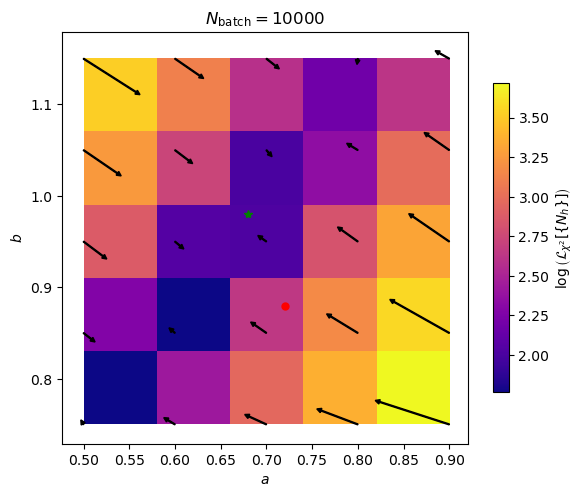

In [19]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow(np.log10((loss_grid * N_events)).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
fig.colorbar(heatmap, ax=ax, label=r'$\log \left(\mathcal{L}_{\chi^2}[\{ N_h \}]\right)$', shrink=0.75)

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/5e1, -gradient[1]/5e1, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], '*', color='green', label = 'Target', ms = 6, linewidth=10)
ax.plot(RSA.params_base[0].clone().detach().numpy(), RSA.params_base[1].clone().detach().numpy(), 'o', color = 'red', label = 'Base', ms = 5, linewidth=10)

ax.set_title(rf'$N_{{\mathrm{{batch}}}} = {N_events}$')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()